## Bayesian Optimization over Discrete and Mixed Spaces via Probabilistic Reparameterization

In this tutorial, we illustrate how to perform Bayesian Optimization (BO) over discrete and mixed spaces via probabilistic reparameterization.

The key idea is that we can optimize an acquisition function $\alpha(x, z)$ with discrete variables $z$ (and potentially continuous variables $ x$) by reparameterizing the discrete variables with random discrete varaibles $ Z$ that are parameterized by continuous parameters $\theta$. This reparameterization enables optimizing the acquisition function by optimizing the following probabilistic objective:
$$\mathbb E_{Z \sim P(Z|\theta)}[\alpha(x, Z)].$$

The probabilistic objective is differentiable with respect to $\theta$ (and $x$ so long as the acquisition function is differentiable with respect to $x$) and hence we can optimize the acquisition function with gradients.

In this tutorial, we demonstrate how to use both an analytic version of probabilistic reparameterization (suitable when there are less than a few thousand discrete options) and a scalable Monte Carlo variant in BoTorch.

S. Daulton, X. Wan, D. Eriksson, M. Balandat, M. A. Osborne, E. Bakshy. [Bayesian Optimization over Discrete and Mixed Spaces via Probabilistic Reparameterization](https://arxiv.org/abs/2210.10199), NeurIPS, 2022. 

In [1]:
import os
from typing import Optional

import numpy as np
import torch
from botorch.models.transforms.factory import get_rounding_input_transform
from botorch.test_functions.synthetic import SyntheticTestFunction
from botorch.utils.sampling import draw_sobol_samples, manual_seed
from botorch.utils.transforms import unnormalize
from torch import Tensor


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
dtype = torch.double
tkwargs = {"dtype": dtype, "device": device}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

I1130 132056.081 _utils_internal.py:179] NCCL_DEBUG env var is set to None


I1130 132056.082 _utils_internal.py:188] NCCL_DEBUG is INFO from /etc/nccl.conf


### Problem setup

Setup a mixed Ackley proble with 10 binary parameters and 3 continuous parameters.

In [2]:
from botorch.test_functions.synthetic import Ackley
dim = 13
base_function = Ackley(dim=dim, negate=True).to(**tkwargs)
# restrict ackley search space
base_function.bounds[0, :-3] = 0
base_function.bounds[1] = 1
base_function.bounds[0, -3:] = -1
# define integer bounds (binary)
integer_bounds = torch.zeros(2, dim - 3, **tkwargs)
integer_bounds[1] = 1  # 2 values
rounding_bounds = base_function.bounds.clone()
integer_indices = list(range(dim - 3))
rounding_bounds[:, integer_indices] = integer_bounds
standard_bounds = torch.zeros_like(rounding_bounds)
standard_bounds[1] = 1

In [3]:

# construct a rounding function for initialization (equal probability for all discrete values)
init_exact_rounding_func = get_rounding_input_transform(
    one_hot_bounds=rounding_bounds, integer_indices=integer_indices, initialization=True
)
# construct a rounding function
exact_rounding_func = get_rounding_input_transform(
    one_hot_bounds=rounding_bounds, integer_indices=integer_indices, initialization=False
)

In [4]:
def eval_problem(X):
    # apply the exact rounding function to make sure
    # that discrete parameters are discretized
    X = exact_rounding_func(X)
    # unnormalize to the problem space
    raw_X = unnormalize(X, base_function.bounds)
    return base_function(raw_X).unsqueeze(-1)

In [5]:
def generate_initial_data(n):
    r"""
    Generates the initial data for the experiments.
    Args:
        n: Number of training points..
    Returns:
        The train_X and train_Y. `n x d` and `n x 1`.
    """
    raw_x = draw_sobol_samples(bounds=standard_bounds, n=n, q=1).squeeze(-2)
    train_x = init_exact_rounding_func(raw_x)
    train_obj = eval_problem(train_x)
    return train_x, train_obj

#### Model initialization

We use a `FixedNoiseGP` to model the outcome. The models are initialized with 20 quasi-random points. We use an isotropic kernel over the binary parameters and an ARD kernel over the continuous parameters.

In [6]:
from typing import Dict, List, Optional

import numpy as np
import torch
from botorch.models import FixedNoiseGP
from botorch.models.kernels import CategoricalKernel
from gpytorch.constraints import GreaterThan, Interval
from gpytorch.kernels import Kernel, MaternKernel, RBFKernel, ScaleKernel
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.priors.torch_priors import GammaPrior, LogNormalPrior
from torch import Tensor


def get_kernel(dim: int, binary_dims: List[int]) -> Kernel:
    """Helper function for kernel construction."""
    # ard kernel for continuous features
    cont_dims = list(set(list(range(dim))) - set(binary_dims))
    cont_kernel = MaternKernel(
        nu=2.5,
        ard_num_dims=len(cont_dims),
        active_dims=cont_dims,
        lengthscale_constraint=Interval(0.1, 20.0),
    )
    # isotropic kernel for binary features
    binary_kernel = MaternKernel(
        nu=2.5,
        ard_num_dims=None,
        active_dims=binary_dims,
        lengthscale_constraint=Interval(0.1, 20.0),
    )
    return ScaleKernel(cont_kernel * binary_kernel)


NOISE_SE = 1e-6
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)


def initialize_model(
    train_x, stdized_train_obj, state_dict=None, exact_rounding_func=None
):
    # define model
    model = FixedNoiseGP(
        train_x,
        stdized_train_obj,
        train_yvar.expand_as(stdized_train_obj),
        input_transform=exact_rounding_func,
        covar_module=get_kernel(dim=dim, binary_dims=integer_indices),
    ).to(train_x)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

#### Define a helper function that performs the essential BO step
The helper function below takes an acquisition function as an argument, optimizes it, and returns the candidate along with the observed function values. 

`optimize_acqf_cont_relax_and_get_observation` uses a continuous relaxation of the discrete parameters and rounds the resulting candidate.

`optimize_acqf_pr_and_get_observation` uses a probabilistic reparameterization.

In [7]:
from botorch.acquisition.probabilistic_reparameterization import (
    AnalyticProbabilisticReparameterization,
    MCProbabilisticReparameterization,
)
from botorch.generation.gen import gen_candidates_scipy, gen_candidates_torch
from botorch.optim import optimize_acqf

NUM_RESTARTS = 20 if not SMOKE_TEST else 2
RAW_SAMPLES = 1024 if not SMOKE_TEST else 32


def optimize_acqf_cont_relax_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=1,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        return_best_only=False,
    )
    # round the resulting candidates and take the best across restarts
    candidates = exact_rounding_func(candidates.detach())
    with torch.no_grad():
        af_vals = acq_func(candidates)
    best_idx = af_vals.argmax()
    new_x = candidates[best_idx]
    # observe new values
    exact_obj = eval_problem(new_x)
    return new_x, exact_obj


def optimize_acqf_pr_and_get_observation(acq_func, analytic):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # construct PR
    if analytic:
        pr_acq_func = AnalyticProbabilisticReparameterization(
            acq_function=acq_func,
            one_hot_bounds=rounding_bounds,
            integer_indices=integer_indices,
            batch_limit=128,
        )
    else:
        pr_acq_func = MCProbabilisticReparameterization(
            acq_function=acq_func,
            one_hot_bounds=rounding_bounds,
            integer_indices=integer_indices,
            batch_limit=128,
            mc_samples=4 if SMOKE_TEST else 128,
        )
    candidates, _ = optimize_acqf(
        acq_function=pr_acq_func,
        bounds=standard_bounds,
        q=1,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={
            "batch_limit": 5,
            "maxiter": 200,
            "rel_tol": float("-inf"),  # run for a full 200 steps
        },
        # use Adam for Monte Carlo PR
        gen_candidates=gen_candidates_torch if not analytic else gen_candidates_scipy,
    )
    # round the resulting candidates and take the best across restarts
    new_x = pr_acq_func.sample_candidates(X=candidates.detach())
    # observe new values
    exact_obj = eval_problem(new_x)
    return new_x, exact_obj


def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(1, base_function.dim, **tkwargs)
    next_random_best = eval_problem(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

### Perform Bayesian Optimization loop

*Note*: Running this may take a little while.

In [8]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.transforms import standardize


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

torch.manual_seed(0)
N_TRIALS = 1
N_BATCH = 15 if not SMOKE_TEST else 2

verbose = True

(
    best_observed_all_pr,
    best_observed_all_pr_analytic,
    best_observed_all_cont_relax,
    best_random_all,
) = ([], [], [], [])


# average over multiple trials
for trial in range(1, N_TRIALS + 1):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    (
        best_observed_pr,
        best_observed_pr_analytic,
        best_observed_cont_relax,
        best_random,
    ) = ([], [], [], [])

    # call helper functions to generate initial training data and initialize model
    train_x_pr, train_obj_pr = generate_initial_data(n=20)
    best_observed_value_pr = train_obj_pr.max().item()
    stdized_train_obj_pr = standardize(train_obj_pr)
    mll_pr, model_pr = initialize_model(train_x_pr, stdized_train_obj_pr)

    train_x_pr_analytic, train_obj_pr_analytic, stdized_train_obj_pr_analytic = (
        train_x_pr,
        train_obj_pr,
        stdized_train_obj_pr,
    )
    best_observed_value_pr_analytic = best_observed_value_pr
    mll_pr_analytic, model_pr_analytic = initialize_model(
        train_x_pr_analytic,
        stdized_train_obj_pr_analytic,
    )

    train_x_cont_relax, train_obj_cont_relax, stdized_train_obj_cont_relax = (
        train_x_pr,
        train_obj_pr,
        stdized_train_obj_pr,
    )
    best_observed_value_cont_relax = best_observed_value_pr
    mll_cont_relax, model_cont_relax = initialize_model(
        train_x_cont_relax,
        stdized_train_obj_cont_relax,
    )

    best_observed_pr.append(best_observed_value_pr)
    best_observed_pr_analytic.append(best_observed_value_pr_analytic)
    best_observed_cont_relax.append(best_observed_value_cont_relax)
    best_random.append(best_observed_value_pr)

    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):

        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_pr)
        fit_gpytorch_mll(mll_pr_analytic)
        fit_gpytorch_mll(mll_cont_relax)

        # for best_f, we use the best observed values
        ei_pr = ExpectedImprovement(
            model=model_pr,
            best_f=stdized_train_obj_pr.max(),
        )

        ei_pr_analytic = ExpectedImprovement(
            model=model_pr_analytic,
            best_f=stdized_train_obj_pr_analytic.max(),
        )

        ei_cont_relax = ExpectedImprovement(
            model=model_cont_relax,
            best_f=stdized_train_obj_cont_relax.max(),
        )

        # optimize and get new observation
        new_x_pr, new_obj_pr = optimize_acqf_pr_and_get_observation(
            ei_pr, analytic=False
        )
        new_x_pr_analytic, new_obj_pr_analytic = optimize_acqf_pr_and_get_observation(
            ei_pr_analytic, analytic=True
        )
        (
            new_x_cont_relax,
            new_obj_cont_relax,
        ) = optimize_acqf_cont_relax_and_get_observation(ei_cont_relax)

        # update training points
        train_x_pr = torch.cat([train_x_pr, new_x_pr])
        train_obj_pr = torch.cat([train_obj_pr, new_obj_pr])
        stdized_train_obj_pr = standardize(train_obj_pr)

        train_x_pr_analytic = torch.cat([train_x_pr_analytic, new_x_pr_analytic])
        train_obj_pr_analytic = torch.cat([train_obj_pr_analytic, new_obj_pr_analytic])
        stdized_train_obj_pr_analytic = standardize(train_obj_pr_analytic)

        train_x_cont_relax = torch.cat([train_x_cont_relax, new_x_cont_relax])
        train_obj_cont_relax = torch.cat([train_obj_cont_relax, new_obj_cont_relax])
        stdized_train_obj_cont_relax = standardize(train_obj_cont_relax)

        # update progress
        best_random = update_random_observations(best_random)
        best_value_pr_analytic = train_obj_pr.max().item()
        best_value_pr = train_obj_pr_analytic.max().item()
        best_value_cont_relax = train_obj_cont_relax.max().item()
        best_observed_pr.append(best_value_pr)
        best_observed_pr_analytic.append(best_value_pr_analytic)
        best_observed_cont_relax.append(best_value_cont_relax)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        mll_pr, model_pr = initialize_model(
            train_x_pr,
            stdized_train_obj_pr,
        )
        mll_pr_analytic, model_pr_analytic = initialize_model(
            train_x_pr_analytic,
            stdized_train_obj_pr_analytic,
        )
        mll_cont_relax, model_cont_relax = initialize_model(
            train_x_cont_relax,
            stdized_train_obj_cont_relax,
        )

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = "
                f"({max(best_random):>4.2f}, {best_value_cont_relax:>4.2f}, {best_value_pr:>4.2f}, {best_value_pr_analytic:>4.2f}), "
                f"time = {t1-t0:>4.2f}.",
                end="",
            )
        else:
            print(".", end="")

    best_observed_all_pr.append(best_observed_pr)
    best_observed_all_pr_analytic.append(best_observed_pr_analytic)
    best_observed_all_cont_relax.append(best_observed_cont_relax)
    best_random_all.append(best_random)


Trial  1 of 1 
Batch  1: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = (-1.98, -1.98, -1.90, -1.98), time = 45.77.
Batch  2: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = (-1.98, -1.98, -1.90, -1.98), time = 64.38.
Batch  3: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = (-1.98, -1.96, -1.74, -1.98), time = 38.69.
Batch  4: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = (-1.98, -1.96, -1.20, -1.84), time = 36.71.
Batch  5: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = (-1.98, -1.96, -1.20, -1.51), time = 35.81.
Batch  6: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = (-1.98, -1.96, -1.20, -1.51), time = 33.21.
Batch  7: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = (-1.98, -1.96, -1.20, -1.51), time = 34.27.
Batch  8: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = (-1.98, -1.83, -1.20, -1.51), time = 36.21.
Batch  9: best_value (random, Cont. Relax., PR (MC), PR (Analytic)) = (-

#### Plot the results
The plot below shows the best objective value observed at each step of the optimization for each of the algorithms.

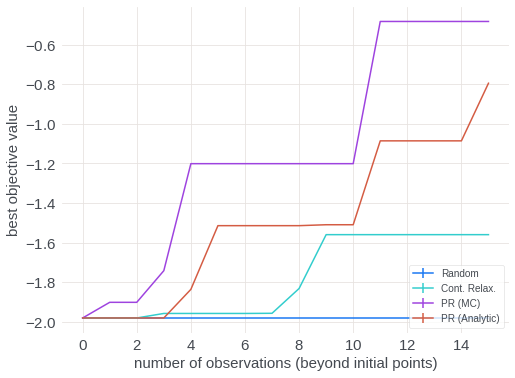

In [9]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


iters = np.arange(N_BATCH + 1)
y_cont_relax = np.asarray(best_observed_all_cont_relax)
y_pr = np.asarray(best_observed_all_pr)
y_pr_analytic = np.asarray(best_observed_all_pr_analytic)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="Random", linewidth=1.5)
ax.errorbar(
    iters,
    y_cont_relax.mean(axis=0),
    yerr=ci(y_cont_relax),
    label="Cont. Relax.",
    linewidth=1.5,
)
ax.errorbar(iters, y_pr.mean(axis=0), yerr=ci(y_pr), label="PR (MC)", linewidth=1.5)
ax.errorbar(iters, y_pr_analytic.mean(axis=0), yerr=ci(y_pr_analytic), label="PR (Analytic)", linewidth=1.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")